In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# import re
# from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

[nltk_data] Downloading package stopwords to C:\Users\Mufid
[nltk_data]     Musyaffa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Mufid
[nltk_data]     Musyaffa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Mufid
[nltk_data]     Musyaffa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Set up Indonesian stopwords and stemmer
# stop_factory = StopWordRemoverFactory()
# stopwords_id = set(stop_factory.get_stop_words())
# stemmer = StemmerFactory().create_stemmer()

# def preprocess_text(text):
#     text = text.lower()
#     text = re.sub(r"http\S+", "", text)
#     text = re.sub(r"@\w+", "", text)
#     text = re.sub(r"#\w+", "", text)
#     text = re.sub(r"[^\w\s]", "", text)
#     text = re.sub(r"\d+", "", text)
#     text = " ".join([word for word in text.split() if word not in stopwords_id])
#     text = stemmer.stem(text)  # stemming in Bahasa Indonesia
#     return text

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

In [3]:
df = pd.read_csv('translated_dataset.csv')

text_column = 'translated_text'
label_column = 'label'

df = df[[text_column, label_column]].dropna()
df[text_column] = df[text_column].astype(str).apply(preprocess_text)

if df[label_column].dtype != int:
    le = LabelEncoder()
    df[label_column] = le.fit_transform(df[label_column])

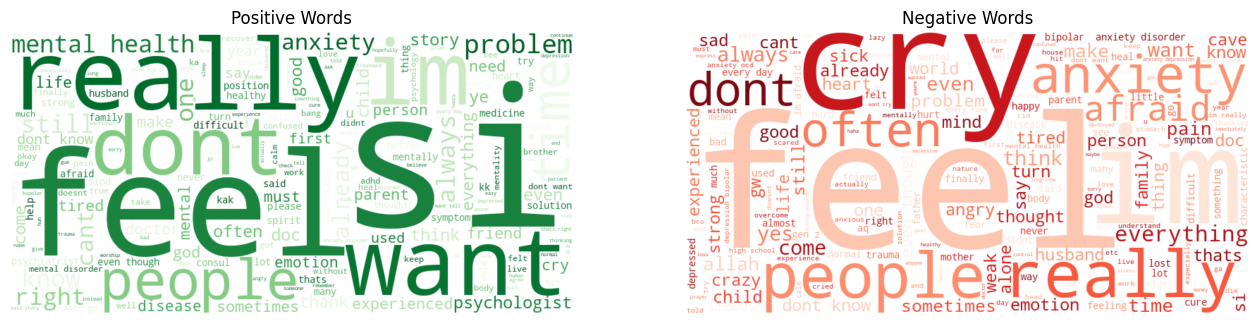

In [4]:
positive_texts = df[df[label_column] == 1][text_column]
negative_texts = df[df[label_column] == 0][text_column]

positive_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(' '.join(positive_texts))
negative_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(' '.join(negative_texts))

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Words')

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words')
plt.show()

In [5]:
vocab_size = 10000
max_len = 100
embedding_dim = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df[text_column])
sequences = tokenizer.texts_to_sequences(df[text_column])
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

word_index = tokenizer.word_index

In [6]:
# embedding_index = {}
# embedding_dim = 300  # FastText Indo = 300 dimensions

# with open('cc.id.300.vec', encoding='utf-8') as f:
#     next(f)  # Skip the header
#     for line in f:
#         values = line.rstrip().split(' ')
#         word = values[0]
#         vector = np.asarray(values[1:], dtype='float32')
#         embedding_index[word] = vector

# embedding_matrix = np.zeros((vocab_size, embedding_dim))
# for word, i in word_index.items():
#     if i < vocab_size:
#         vector = embedding_index.get(word)
#         if vector is not None:
#             embedding_matrix[i] = vector

embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    padded, df[label_column], test_size=0.2, random_state=42)

In [8]:
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=True),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, max_len))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

c:\Users\Mufid Musyaffa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,129,921 (4.31 MB)

 Trainable params: 1,129,921 (4.31 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=15, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 68ms/step - accuracy: 0.7270 - loss: 0.9168 - val_accuracy: 0.7651 - val_loss: 0.5228
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.7875 - loss: 0.4975 - val_accuracy: 0.7772 - val_loss: 0.4873
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.8253 - loss: 0.4090 - val_accuracy: 0.7811 - val_loss: 0.4944
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.8515 - loss: 0.3613 - val_accuracy: 0.7765 - val_loss: 0.5283
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.8733 - loss: 0.3300 - val_accuracy: 0.7494 - val_loss: 0.5258


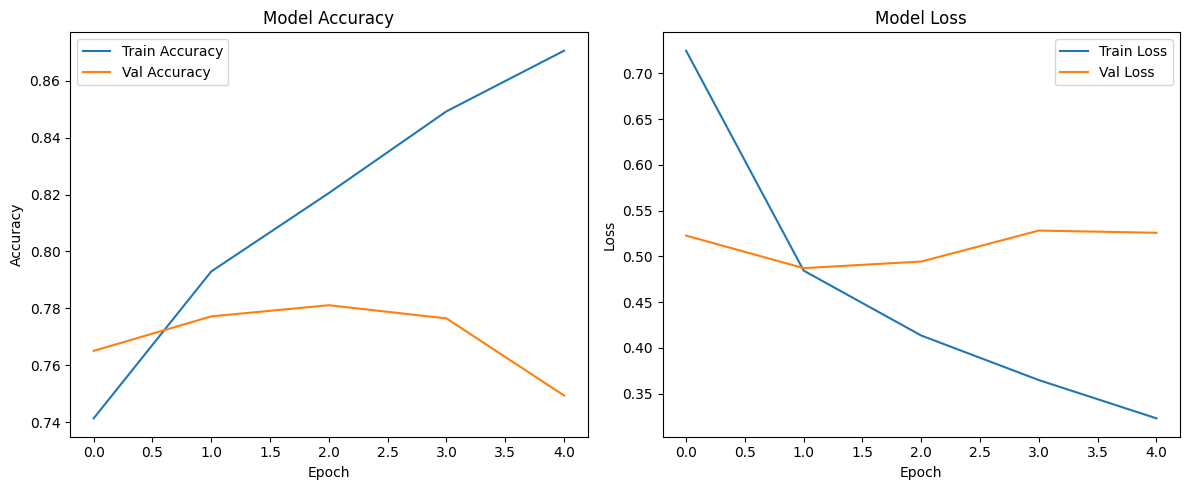

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


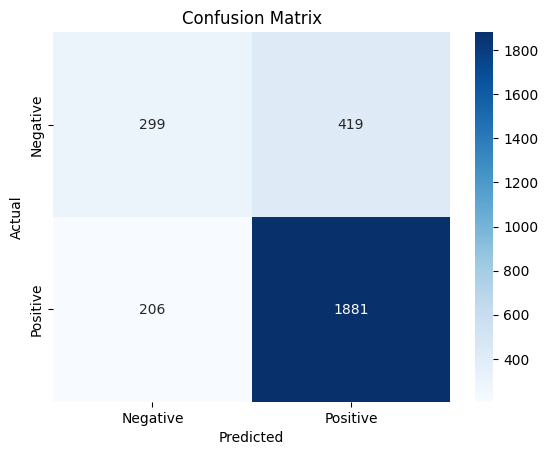


Classification Report:

              precision    recall  f1-score   support

    Negative       0.59      0.42      0.49       718
    Positive       0.82      0.90      0.86      2087

    accuracy                           0.78      2805
   macro avg       0.70      0.66      0.67      2805
weighted avg       0.76      0.78      0.76      2805



In [11]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

In [17]:
model.save('sentiment_model.h5')